# GraphSAGE

Inspired by [@maximelabonne](https://twitter.com/maximelabonne).


In [1]:
# We assume that PyTorch is already installed
import os
import torch

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html --target=/kaggle/working/
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html --target=/kaggle/working/
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git --target=/kaggle/working/

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.2 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.26.2 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.1

# Dataset

In [2]:
!wget https://nrvis.com/download/data/labeled/FRANKENSTEIN.zip
!unzip FRANKENSTEIN.zip

--2023-12-11 18:33:53--  https://nrvis.com/download/data/labeled/FRANKENSTEIN.zip
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14030729 (13M) [application/zip]
Saving to: ‘FRANKENSTEIN.zip’

FRANKENSTEIN.zip    100%[===================>]  13.38M  11.5MB/s    in 1.2s    

2023-12-11 18:33:55 (11.5 MB/s) - ‘FRANKENSTEIN.zip’ saved [14030729/14030729]

Archive:  FRANKENSTEIN.zip
  inflating: FRANKENSTEIN.edges      
  inflating: readme.html             
  inflating: FRANKENSTEIN.graph_idx  
  inflating: FRANKENSTEIN.graph_labels  
  inflating: FRANKENSTEIN.node_attrs  
  inflating: FRANKENSTEIN.readme     


In [3]:
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, DataLoader
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm

In [4]:
raw_dir = ""

path = os.path.join(raw_dir, 'FRANKENSTEIN.node_attrs')
node_attrs = pd.read_csv(path, sep=',', header=None)
node_attrs.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.edges')
edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
edge_index.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_idx')
graph_idx = pd.read_csv(path, sep=',', names=['idx'])
graph_idx.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_labels')
graph_labels = pd.read_csv(path, sep=',', names=['label'])
graph_labels.index += 1

##TASK 1

Load FRANKENSTEIN dataset. (SEE THE SEMINAR 4)

Split it to train, validation and test parts.

Get some statistics.

**5 points**

In [98]:
from torch_geometric.transforms import RandomLinkSplit

data_list =[]
    
for g_idx in tqdm(graph_idx['idx'][:]):
    node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index

    # Node features
    attributes = node_attrs.loc[node_ids, :]

    # Edges info
    edges = edge_index.loc[edge_index['source'].isin(node_ids)]
    edges_ids = edges.index

    # Graph label
    label = graph_labels.loc[g_idx]

    edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
    map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
    map_edge = torch.zeros_like(edge_idx)
    for k,v in map_dict.items():
        map_edge[edge_idx==k] = v

    attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
    pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
    x = torch.cat((attrs, pad), dim=-1)

    edge_idx = map_edge.long()

    np_lab = label.to_numpy()
    y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)


    # Create data object
    data = Data(x=x, edge_index=edge_idx,  y=y)
    data_list.append(data)

100%|██████████| 73283/73283 [06:52<00:00, 177.46it/s]


In [6]:
class Frankenstein(InMemoryDataset):

    # Base url to download the files
    url = 'http://nrvis.com/download/data/labeled/FRANKENSTEIN.zip'

    def __init__(self, root, transform=None, pre_transform=None):
        super(Frankenstein, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # List of the raw files
        return ['FRANKENSTEIN.edges', 'FRANKENSTEIN.graph_idx',
                'FRANKENSTEIN.graph_labels', 'FRANKENSTEIN.node_attrs']

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        # Download the file specified in self.url and store
        # it in self.raw_dir
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        # The zip file is removed
        os.unlink(path)


    def process(self):
        # Read the files' content as Pandas DataFrame. Nodes and graphs ids
        # are based on the file row-index, we adjust the DataFrames indices
        # by starting from 1 instead of 0.

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.node_attrs')
        node_attrs = pd.read_csv(path, sep=',', header=None)
        node_attrs.index += 1

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.edges')
        edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
        edge_index.index += 1

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.graph_idx')
        graph_idx = pd.read_csv(path, sep=',', names=['idx'])
        graph_idx.index += 1

        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.graph_labels')
        graph_labels = pd.read_csv(path, sep=',', names=['label'])
        graph_labels.index += 1


        # In the loop we extract the nodes' embeddings, edges connectivity for
        # and label for a graph, process the information and put it in a Data
        # object, then we add the object to a list
        data_list = []
        ids_list = graph_idx['idx'].unique()
        for g_idx in tqdm(ids_list):
            node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index

            # Node features
            attributes = node_attrs.loc[node_ids, :]

            # Edges info
            edges = edge_index.loc[edge_index['source'].isin(node_ids)]
            edges_ids = edges.index

            # Graph label
            label = graph_labels.loc[g_idx]

            # Normalize the edges indices
            edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
            map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
            map_edge = torch.zeros_like(edge_idx)
            for k,v in map_dict.items():
                map_edge[edge_idx==k] = v

            # Convert the DataFrames into tensors
            attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
            pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
            x = torch.cat((attrs, pad), dim=-1)

            edge_idx = map_edge.long()

            np_lab = label.to_numpy()
            y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)

            graph = Data(x=x, edge_index=edge_idx,  y=y)

            data_list.append(graph)

        # Apply the functions specified in pre_filter and pre_transform
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        # Store the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [7]:
import torch_geometric.transforms as T

In [8]:
dataset = Frankenstein(root='data', pre_transform=T.GCNNorm())

Extracting data/raw/FRANKENSTEIN.zip
Processing...
100%|██████████| 4337/4337 [00:23<00:00, 184.08it/s]
Done!


In [9]:
len(dataset)

4337

In [10]:
train_dataset = dataset[:3000]
val_dataset = dataset[3000:3500]
test_dataset = dataset[3500:]

In [109]:
data = dataset[0]
train_data = train_dataset[0]
val_data = val_dataset[0]
test_data = test_dataset[0]

In [12]:
# lets check some graph statistics of ogb-product graph
print("Number of nodes in the graph:", data.num_nodes)
print("Number of edges in the graph:", data.num_edges)
print("Node feature matrix with shape:", data.x.shape) # [num_nodes, num_node_features]
print("Graph connectivity in COO format with shape:", data.edge_index.shape) # [2, num_edges]
print("Target to train against :", data.y.shape)
print("Node feature length", dataset.num_features)

Number of nodes in the graph: 25
Number of edges in the graph: 81
Node feature matrix with shape: torch.Size([25, 784])
Graph connectivity in COO format with shape: torch.Size([2, 81])
Target to train against : torch.Size([1])
Node feature length 784


# Working Principles of GraphSage

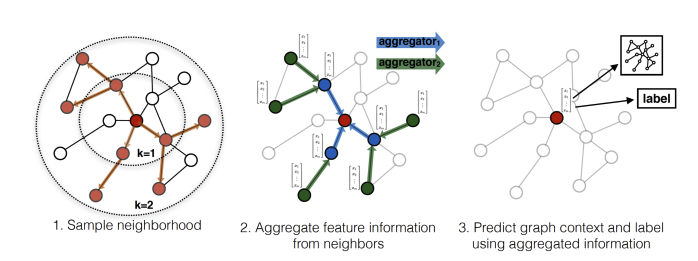

The working process of GraphSage is mainly divided into two steps, first performing <b>neighborhood sampling</b>  of an input graph and the second one is <b>learning aggregation functions</b> at each search depth. We will discuss each of these steps in detail starting with a little motivation of what was the need to perform the sampling of nodes neighborhood. Afterwards, we will discuss the importance of learning aggregator functions which basically had helped GraphSage algorithm to achieve its property of <b>inductiveness</b>.

# Mini-batching

## What is the importance of Neighborhood Sampling?

Lets understand this from the perspective of Graph Convolutional Network diagram (GCNs) described below. GCNs is an algorithm which can leverage both the graph topological information (i.e. node's neighborhood) and node features and then distill this  information in order to generate node representations or dense vector embeddings. The below diagram represents the working process of GCNs intuitively. On the left hand side we have a sample input graph where its nodes are represented by their corresponding feature vectors (for e.g. node degree or text embeddings, etc). We start with defining a search depth (K) which informs the algorithm upto what depth it should gather the information from the neighborhood of a target node. Here, K is a hyperparameter and it also depicts the number of layers used in the GCNs.

At K=0, GCNs initializes all the node embeddings to their original feature vector. Now, let's say we want to compute the embeddings for the target node <i>0</i> at layer K=1, then we <b>aggregate</b> (it is permutation
invariant function to its neighbors) all the feature vectors of nodes (including itself) which are at 1-hop distance from the node <i>0</i> (at this timestep or layer we are aggregating the original feature representations of nodes which are at K=0). For the target node <i>0</i>, GCNs uses a mean aggregator to compute the mean of the neighborhood node features along with its own features (self-loop). After K=1, the target node <i>0</i> now knows about the information about its immediate neighborhood; this process is shown below in the GCNs image (r.h.s). We repeat this process for all the nodes in the graph (i.e. for every node, we aggregate over the 1-hop neighborhood) in order to find the new representations for each node at each layer.

<b>Note:</b> As the search depth increases, the reach of the target node in terms of aggregating features from its local neighborhood also increases. For e.g. at K=1 the target node knows the information about its local neighborhood which are 1-hop distance, at K=2 the target node knows the information about its local neighborhood which are at 1-hop distance and the neighbors of the nodes of 1-hop distance i.e upto 2-hop distance.

## Issues with GCN approach
As we have discussed above, that GCNs compute node representations using neighborhood aggregation. For the training purposes, we can represent the k-hop neighborhood of a target node as a computational graph and send these computational graphs in a mini-batch fashion in order to learn the weights of the network (i.e. applying stochastic gradient descent). The below diagram illustrates a computational graph for the target node 0 upto 2-hop neighborhood. Now, the problem with this is that:

1) <b>Computationally Expensive</b>: Since for each node, we need to generate the complete K-hop neighborhood computational graph and then need to aggregate plenty of information from its surroundings. As we go deeper into the neighborhood (large K) computation graph becomes exponentially large. This could lead to a problem while fitting these big computational graphs inside GPU memory.

2) <b>The curse of Hub nodes or Celebrity nodes</b>: Hub nodes are those nodes which are very high degree nodes in the graph for eg. a very popular celebrity having millions of connections. If that is the case then we need to aggregate the information from millions of nodes in order to compute the embeddings for the hub node. Therefore, the generated computational graph for the hub node is very huge. This problem is illustrated below diagramatically (r.h.s).

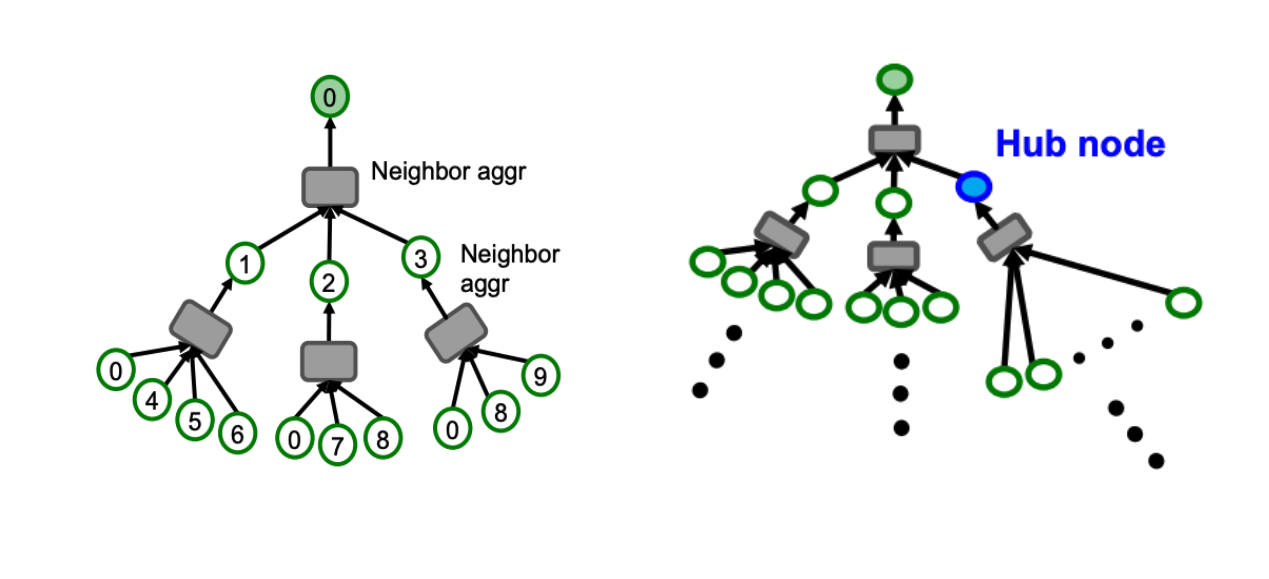

Therefore, the idea is not take the entire K-hop neighborhood of a target node but select few nodes at random from the K-hop neighborhood in order to generate computational graph. This process is known as neighborhood sampling which provides the GraphSage algorithm its unique ability of <b>scaling up to billion of nodes</b> in the graph. Therefore, using this approach if we encounter any hub node then we are not going to take its entire K-hop neighborhood but rather select few nodes at random from each layer or search depth K. Now, the generated computational graph is more efficient to handle by the GPU. Below diagram shows this process by sampling at most 2 neighbors at each hop.

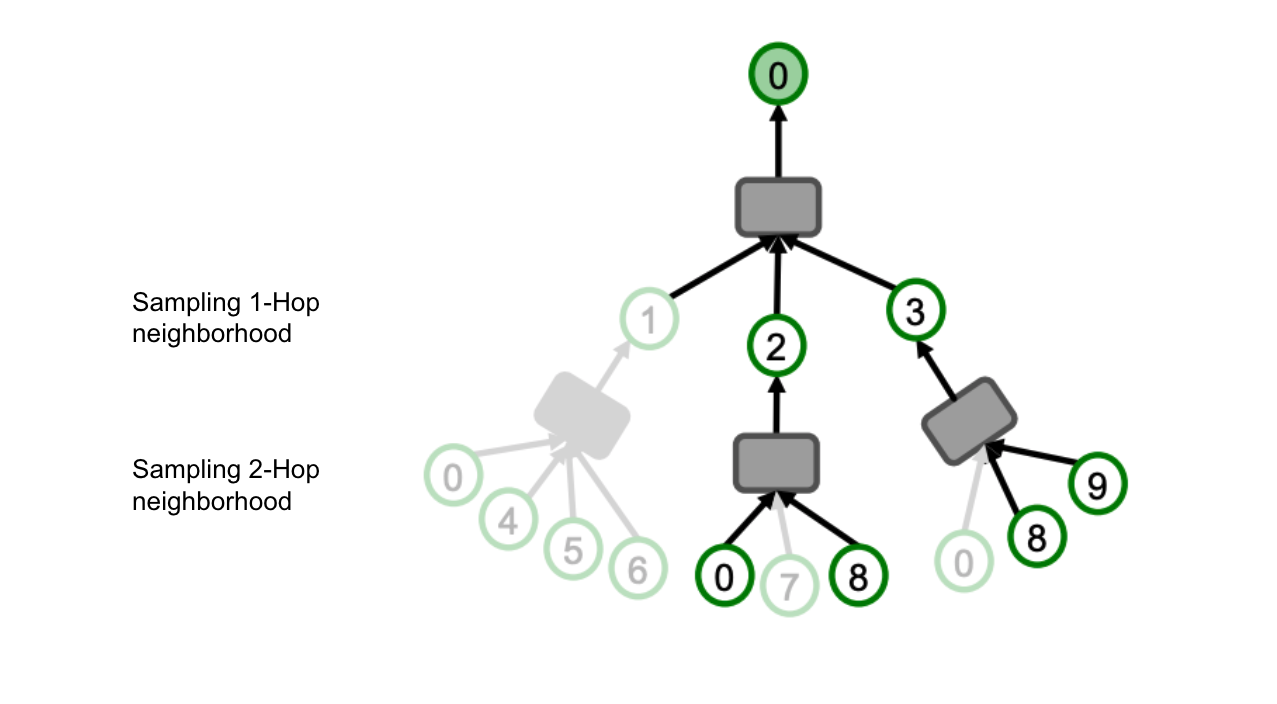

### TASK 2

Addapt the following code for your data


**3 points**

# Plot node degrees

Subgraph 0: ('x', tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
Subgraph 1: ('edge_index', tensor([[ 0,  1,  0,  2,  0,  3,  1,  4,  1,  5,  2,  6,  2,  7,  3,  8,  4,  9,
          4, 10,  5,  8,  6, 11,  7, 12,  8, 13,  9, 14, 10, 15, 11, 16, 12, 16,
         13, 17, 13, 18, 14, 19, 15, 19, 17, 20, 18, 21, 20, 22, 21, 22, 22, 23,
         23, 24,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24],
        [ 1,  0,  2,  0,  3,  0,  4,  1,  5,  1,  6,  2,  7,  2,  8,  3,  9,  4,
         10,  4,  8,  5, 11,  6, 12,  7, 13,  8, 14,  9, 15, 10, 16, 11, 16, 12,
         17, 13, 18, 13, 19, 14, 19, 15, 20, 17, 21, 18, 22, 20, 22, 21, 23, 22,
         24, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
      

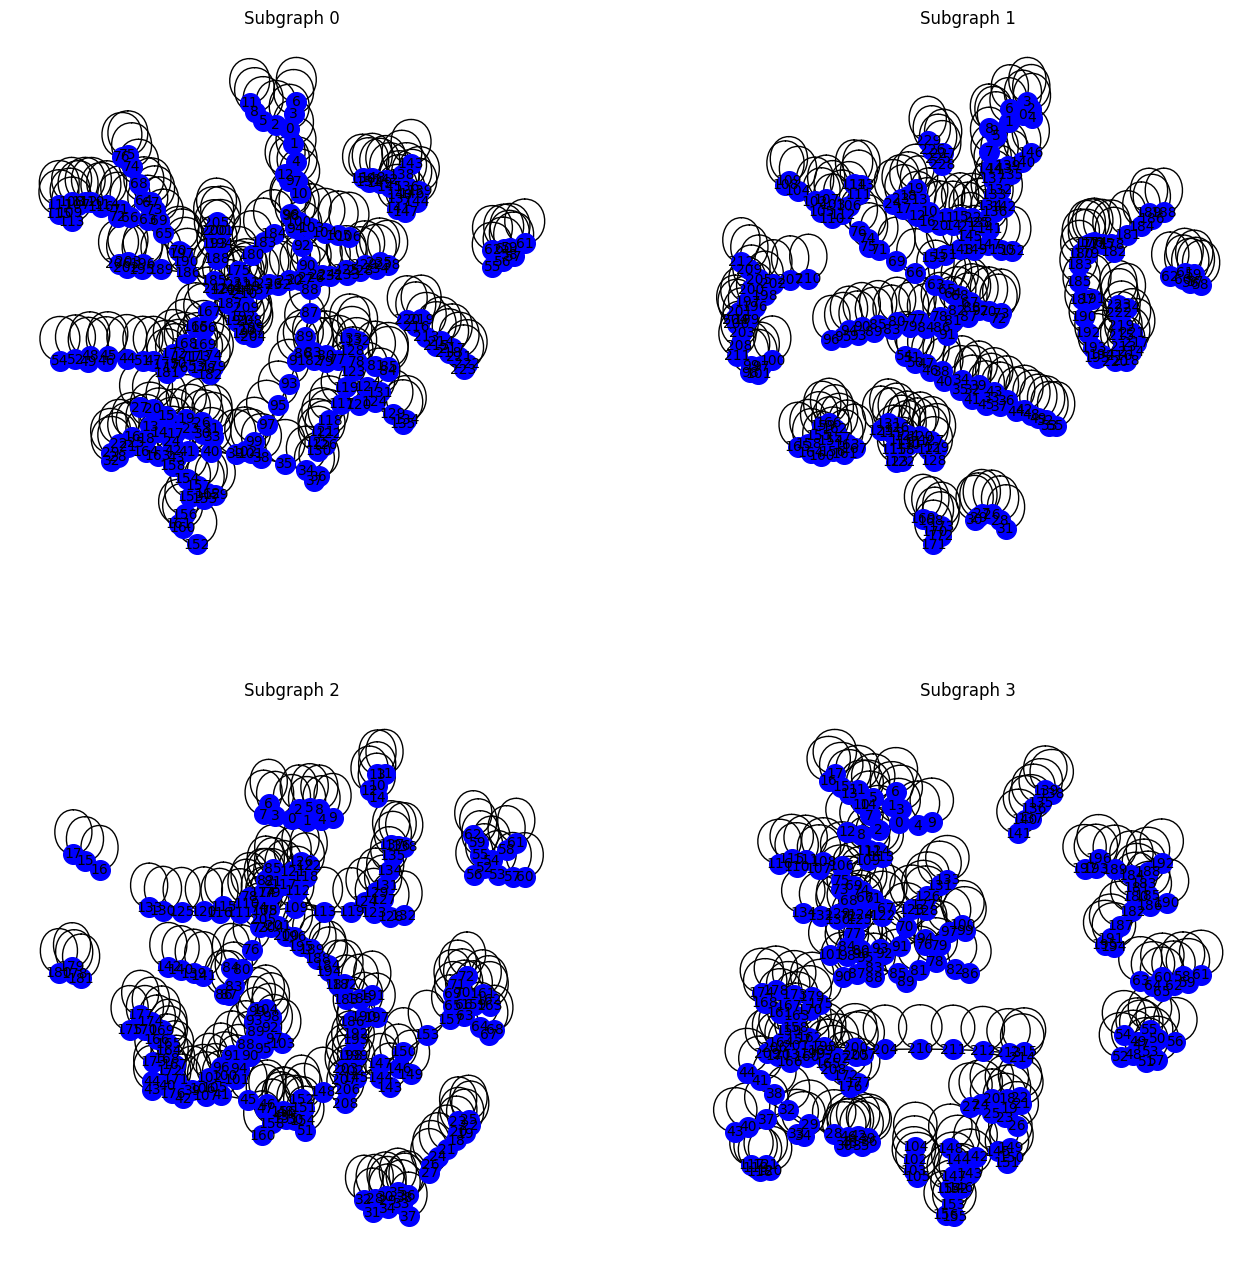

In [95]:
from torch_geometric.utils import to_networkx

# Print each subgraph
for i, subgraph in enumerate(data):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(test_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color='blue',
                    cmap="cool",
                    font_size=10,
                    )
plt.show()

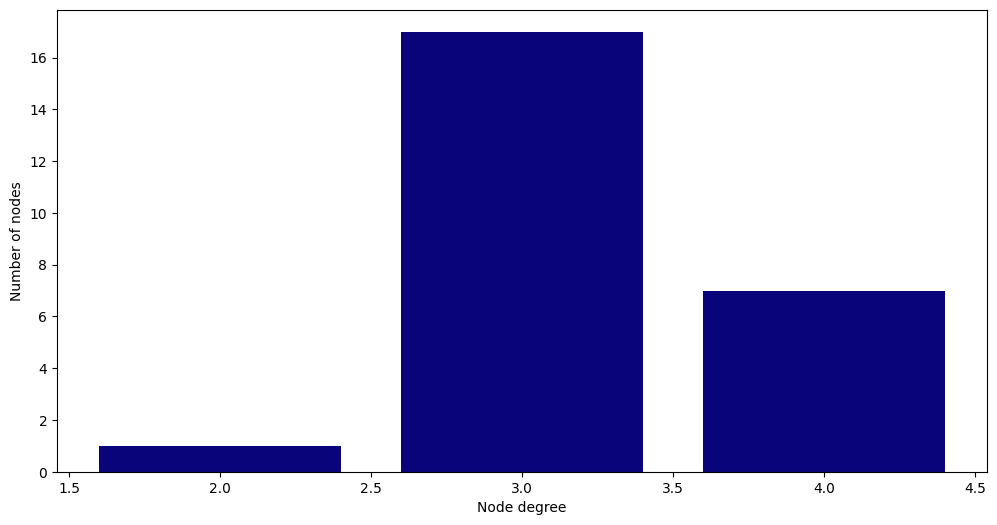

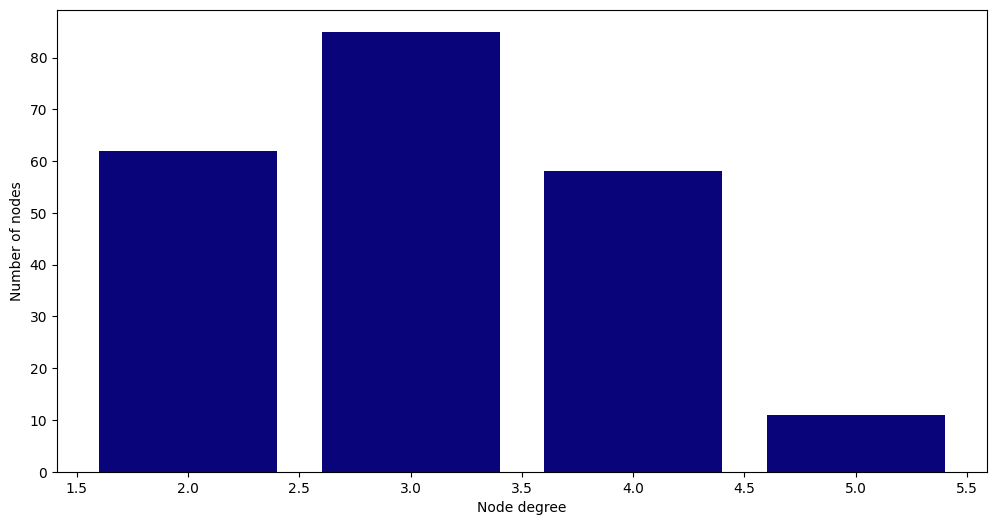

In [110]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
    # Get list of degrees for each node
    degrees = degree(data.edge_index[0]).numpy()

    # Count the number of nodes for each degree
    numbers = Counter(degrees)

    # Bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(),
            numbers.values(),color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Implement GraphSage vs.  GCN

The key concept of GraphSage is to learn how to aggregate feature information from a node’s local neighborhood. Now, let's understand more formally how the GraphSage generates node embedding at each layer (K) using forward propagation. We understand this with the help of visuals and then map this understanding to a pseudocode mentioned in the [GraphSage paper](https://arxiv.org/pdf/1706.02216.pdf). But before that, lets define some notations which are used in the paper.

## Defining Notations:

x<sub>v</sub> = Feature vector of a node <b>v</b>

h<sub>v</sub><sup>0</sup> = Initial node embeddings representation for a node <b>v</b> (original feature vectore e.g. text or image embeddings)

h<sub>v</sub><sup>k</sup>  = Node embedding representation for a node <b>v</b> at the K-th layer or search depth

z<sub>v</sub> = Final representation of a node <b>v</b> after K layers

V = Set of nodes in the graph

W<sup>K</sup> = Weight matrix at the K-th layer

<i>N</i> : v → 2<sup>v</sup> = Neighborhood function

As seen in the above GraphSage diagram that at K=1, the target node <b>0</b> aggregates information (features) from its local neighbors upto 1-hop. Similarly at k=2, the target node <b>0</b> aggregates information from its local neighbors upto 2-hops i.e now it knows what lies in its neighborhood upto 2-hops. Therefore, we can iterate this process where target node <b>0</b> incrementally obtain more and more
information from further reaches of the graph. We do this process of information gathering for each of the nodes in the original graph (∀v ∈ V).
Lets add some visuals to understand this iterative process much more intuitively:

The following image depicts the computation graph of target node <b>0</b> at layer K=0, at this point of time all the nodes in the graph are initialized to their original feature vectors. Our aim is to find the final representation of node <b>0</b> (i.e z<sub>0</sub>) at layer K=2 through an iterative local neighborhood information gathering process. This iterative process is also sometime known as <b>message passing approach </b>.

Therefore, we can represent this step formally as :

# <b>h<sub>v</sub><sup>0</sup> ← x<sub>v</sub>, ∀v ∈ V </b>

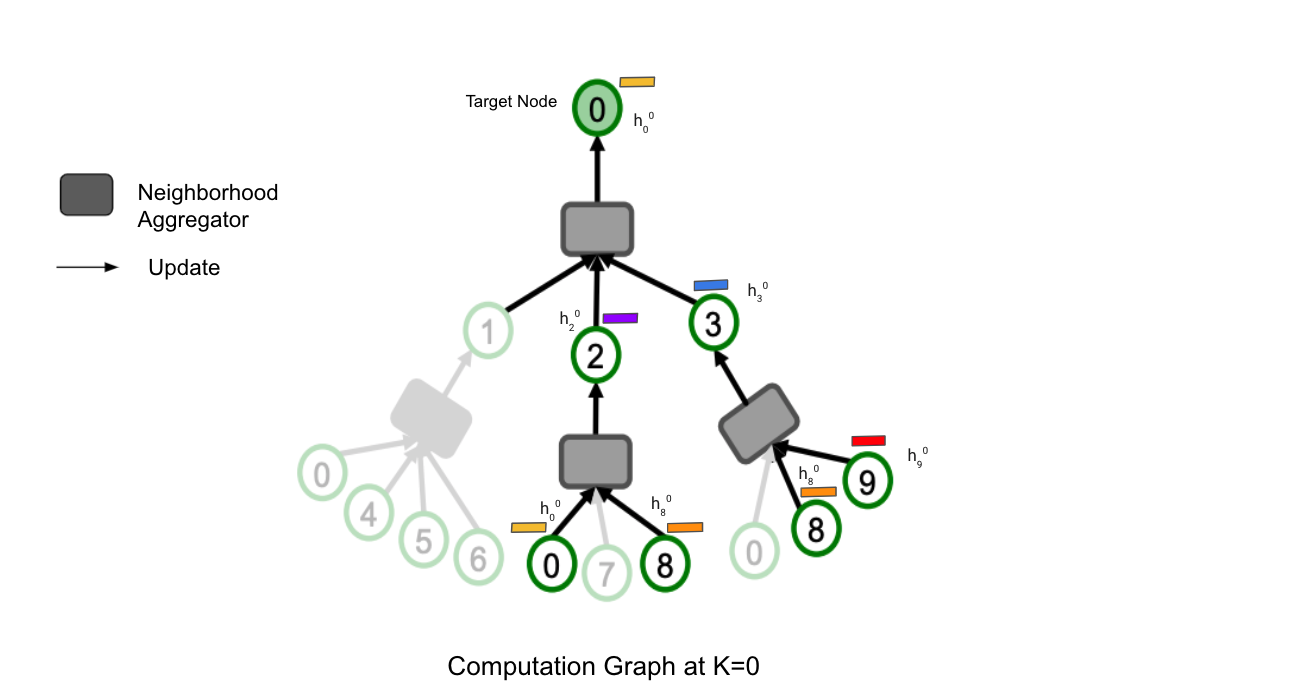

## TASK 3

Use batch masking or replace batch.train_mask, batch.val_mask, batch.test_mask to your corresponding data

**3 points**

# Implement GraphSAGE

In [74]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GCNConv

class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.1,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

    def fit(self, train_data, val_data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = self.optimizer

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in train_data:
                optimizer.zero_grad()
                _, out = self(batch.x, batch.edge_index)
                unique_batches, inverse_indices = torch.unique(batch.batch, return_inverse=True)
                expanded_y = torch.index_select(batch.y, dim=0, index=inverse_indices)
                loss = criterion(out, expanded_y)
                total_loss += loss
                acc += accuracy(out.argmax(dim=1),
                                expanded_y)
                loss.backward()
                optimizer.step()
            for batch in val_data:
                # Validation
                _, out = self(batch.x, batch.edge_index)
                unique_batches, inverse_indices = torch.unique(batch.batch, return_inverse=True)
                expanded_y = torch.index_select(batch.y, dim=0, index=inverse_indices)
                val_loss += criterion(out, expanded_y)
                val_acc += accuracy(out.argmax(dim=1),
                            expanded_y)

      # Print metrics every 10 epochs
            if(epoch % 10 == 0):
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                      f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                      f'{val_loss/len(val_loader):.2f} | Val Acc: '
                      f'{val_acc/len(val_loader)*100:.2f}%')

# Implement GCN

In [75]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

    def fit(self, train_data, val_data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = self.optimizer

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in train_data:
                optimizer.zero_grad()
                _, out = self(batch.x, batch.edge_index)
                unique_batches, inverse_indices = torch.unique(batch.batch, return_inverse=True)
                expanded_y = torch.index_select(batch.y, dim=0, index=inverse_indices)
                loss = criterion(out, expanded_y)
                total_loss += loss
                acc += accuracy(out.argmax(dim=1),
                                expanded_y)
                loss.backward()
                optimizer.step()
            for batch in val_data:
                # Validation
                _, out = self(batch.x, batch.edge_index)
                unique_batches, inverse_indices = torch.unique(batch.batch, return_inverse=True)
                expanded_y = torch.index_select(batch.y, dim=0, index=inverse_indices)
                val_loss += criterion(out, expanded_y)
                val_acc += accuracy(out.argmax(dim=1),
                            expanded_y)

            # Print metrics every 10 epochs
            if(epoch % 10 == 0):
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                      f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                      f'{val_loss/len(val_loader):.2f} | Val Acc: '
                      f'{val_acc/len(val_loader)*100:.2f}%')

##TASK 4

Make a comparsion of two networks

**4 points**

# Compare GraphSAGE and GCN

In [80]:
def accuracy(pred_y, y):
        """Calculate accuracy."""
        return ((pred_y == y).sum() / len(y)).item()

def test(model, test_data):
        """Evaluate the model on test set and print the accuracy score."""
        model.eval()
        acc = 0
        for batch in test_data:
            _, out = model(batch.x, batch.edge_index)
            unique_batches, inverse_indices = torch.unique(batch.batch, return_inverse=True)
            expanded_y = torch.index_select(batch.y, dim=0, index=inverse_indices)
            acc+= accuracy(out.argmax(dim=1), expanded_y)
        return acc/len(test_data)

In [81]:
import time

#test GraphSAGE
start_time = time.time()
graphsage.fit(train_loader, val_loader, epochs=200)
end_time = time.time()
acc_graphsage = test(graphsage, test_loader)

print(f'GraphSAGE Training Time: {end_time - start_time:.2f} seconds')
print(f'\nGraphSAGE test accuracy: {acc_graphsage*100:.2f}%\n')

#test GCN
start_time = time.time()
gcn.fit(train_loader, val_loader, epochs=200)
end_time = time.time()
acc_gcn = test(gcn, test_loader)

print(f'GCN Training Time: {end_time - start_time:.2f} seconds')
print(f'\nGCN test accuracy: {acc_gcn*100:.2f}%\n')

Epoch   0 | Train Loss: 0.004 | Train Acc:  56.36% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch  10 | Train Loss: 0.003 | Train Acc:  57.86% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch  20 | Train Loss: 0.003 | Train Acc:  58.52% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch  30 | Train Loss: 0.004 | Train Acc:  56.60% | Val Loss: 0.72 | Val Acc: 38.79%
Epoch  40 | Train Loss: 0.003 | Train Acc:  58.12% | Val Loss: 0.67 | Val Acc: 61.24%
Epoch  50 | Train Loss: 0.004 | Train Acc:  58.36% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch  60 | Train Loss: 0.004 | Train Acc:  57.26% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch  70 | Train Loss: 0.004 | Train Acc:  58.39% | Val Loss: 0.68 | Val Acc: 61.21%
Epoch  80 | Train Loss: 0.004 | Train Acc:  57.52% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch  90 | Train Loss: 0.004 | Train Acc:  58.13% | Val Loss: 0.67 | Val Acc: 61.21%
Epoch 100 | Train Loss: 0.004 | Train Acc:  57.60% | Val Loss: 0.70 | Val Acc: 38.79%
Epoch 110 | Train Loss: 0.004 | Train Acc:  57.73% | V

# Conclusions

NeighborLoader for GraphSAGE inappropriate in this case because dataset small enough and the average number of neighbors per node is small. Using of DataLoader will be easer and more efficient.
However, even with DataLoader GCN about 28% faster than GraphSAGE with almost the same accuracy on all of samples for this dataset.